In [251]:
import json
from collections import Counter 
import time
import os
import seaborn as sns; sns.set_theme()
import pandas as pd

In [252]:
import graph_tool.all as gt

In [253]:
%load_ext autoreload
%autoreload 2

from collections import Counter,defaultdict
from generate_graph import make_graph,make_network
import GenModel as GM
import numpy as np
import networkx as nx
import pickle
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import infomap
import socialonline_stats as SS
import plotly.graph_objects as go
from plotly.subplots import make_subplots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Social Networks

* facebook_organizations：friendships among users on Facebook who indicated employment at one of the target corporation
* ego_social: Ego networks associated with a set of accounts of Facebook
* facebook_friends: A small anonymized Facebook ego network
* uni_email: A network representing the exchange of emails among members of the Rovira i Virgili University in Spain, in 2003.
* new_zealand_collab: A network of scientific collaborations among institutions in New Zealand. Nodes are institutions (universities, organizations, etc.), and two nodes i,j are connected if Scopus lists at least one publication with authors at institutions i and j, in the period 2010-2015. Edges are weighted by the number of such collaborations.

* advogato: A network of trust relationships among users on Advogato, an online community of open source software developers.

* anybeat: A snapshot of the Anybeat online social network from 2013, before it was shut down. Nodes are users and links represent friendships. The edge direction (i, j) denotes the user i follows user j.
* digg_reply: Network of replies among users of digg.com. Each node in the network is a digg user, and each directed edge indicates that user i replied to user j.
* arxiv_collab: Collaboration graphs for scientists
* twitter_15m: A network representing follower-following relations among Twitter users associated with the 15-M Movement or Anti-austerity movement in Spain, in the period April-May 2011.

## Download

In [1]:
fnames = ["facebook_organizations","ego_social","facebook_friends",\
          "uni_email","new_zealand_collab","bitcoin_alpha","bitcoin_trust",\
          "advogato","elec", "anybeat", "digg_reply","arxiv_collab","twitter_15m"]

In [124]:
g = gt.collection.ns["facebook_friends"]
g.save("../Data/OriginalData/facebook_friends.xml.gz")

In [125]:
g = gt.collection.ns["uni_email"]
g.save("../Data/OriginalData/uni_email.xml.gz")

In [126]:
g = gt.collection.ns["new_zealand_collab"]
g.save("../Data/OriginalData/new_zealand_collab.xml.gz")

In [129]:
g = gt.collection.ns["facebook_organizations/S1"]
g.save("../Data/OriginalData/facebook_organizations.xml.gz")
g = gt.collection.ns["facebook_organizations/S2"]
g.save("../Data/OriginalData/facebook_organizations2.xml.gz")
g = gt.collection.ns["facebook_organizations/M1"]
g.save("../Data/OriginalData/facebook_organizations3.xml.gz")
g = gt.collection.ns["facebook_organizations/M2"]
g.save("../Data/OriginalData/facebook_organizations4.xml.gz")
g = gt.collection.ns["facebook_organizations/L1"]
g.save("../Data/OriginalData/facebook_organizations5.xml.gz")
g = gt.collection.ns["facebook_organizations/L2"]
g.save("../Data/OriginalData/facebook_organizations6.xml.gz")

In [131]:
g = gt.collection.ns["advogato"]
g.save("../Data/OriginalData/advogato.xml.gz")

In [133]:
g = gt.collection.ns["anybeat"]
g.save("../Data/OriginalData/anybeat.xml.gz")

In [134]:
g = gt.collection.ns["digg_reply"]
g.save("../Data/OriginalData/digg_reply.xml.gz")

In [135]:
g = gt.collection.ns["arxiv_collab/cond-mat-1999"]
g.save("../Data/OriginalData/arxiv_collab.xml.gz")

In [136]:
g = gt.collection.ns["twitter_15m"]
g.save("../Data/OriginalData/twitter_15m.xml.gz")

In [137]:
g = gt.collection.ns["ego_social/facebook_0"]
g.save("../Data/OriginalData/ego_social.xml.gz")

In [ ]:
g = gt.load_graph_from_csv('../Data/Moscowedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/Moscow.xml.gz")

g = gt.load_graph_from_csv('../Data/NYClimateedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/NYClimate.xml.gz")

g = gt.load_graph_from_csv('../Data/MLKingedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/MLKing.xml.gz")

g = gt.load_graph_from_csv('../Data/Cannesedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/Cannes.xml.gz")

In [241]:
g = gt.load_graph_from_csv('../Data/Moscowreplyedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/Moscowreply.xml.gz")

g = gt.load_graph_from_csv('../Data/NYClimatereplyedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/NYClimatereply.xml.gz")

g = gt.load_graph_from_csv('../Data/MLKingreplyedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/MLKingreply.xml.gz")

g = gt.load_graph_from_csv('../Data/Cannesreplyedges.csv', skip_first=True, directed=True, eprop_types = ["int"],eprop_names=['weight'])
g.save("../Data/OriginalData/Cannesreply.xml.gz")

In [224]:
g = gt.load_graph("../Data/ProcessedData/advogato.xml.gz")
g.vp

{'_pos': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1790627f0, at 0x179060550>, 'meta': <VertexPropertyMap object with value type 'string', for Graph 0x1790627f0, at 0x17905b460>, 'title': <VertexPropertyMap object with value type 'string', for Graph 0x1790627f0, at 0x17905b160>}

## Louvian

In [5]:
from community import community_louvain

In [7]:
%%time
for fname in fnames:
    path_data = "../Data"
    fname_data = fname + ".xml.gz"
    filename = os.path.join(path_data,fname_data)

    G_gt = gt.load_graph(filename)
    vp_name = "title"
    ep_name = None
    G_nx =G_nx = GM.convert_gt_to_nx(G_gt, vp_name=vp_name,ep_name=ep_name)
    
    louvain_par = GM.Louvain_partition(G_nx,iteration = 10)
    
    path_data = "../Outputs"
    name_data = fname + "_louvian.par"
    filename = os.path.join(path_data,name_data)
    with open(filename,"wb") as f:
        pickle.dump(louvain_par,f)



CPU times: user 6min 2s, sys: 2.38 s, total: 6min 4s
Wall time: 6min 4s


## Infomap

In [9]:
for fname in fnames:
    path_data = "../Data"
    fname_data = fname + ".xml.gz"
    filename = os.path.join(path_data,fname_data)

    G_gt = gt.load_graph(filename)
    vp_name = "title"
    ep_name = None
    G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(),counts = False,vp_name = vp_name,ep_name = ep_name)
    
    im = infomap.Infomap("--two-level")
    im.add_networkx_graph(G_nx)
    im.run()
    communities = im.get_modules()
    
    path_data = "../Outputs"
    name_data = fname + "_info.list"
    filename = os.path.join(path_data,name_data)
    with open(filename,"wb") as f:
        pickle.dump(list(communities.values()),f)



## Spectral clustering

In [25]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath('matlab')
eng.addpath('matlab/spectral_subroutines')

'/Users/liuxuanchi/Desktop/API/src/matlab:/Users/liuxuanchi/Documents/MATLAB:/Applications/MATLAB_R2022a.app/toolbox/matlab/addon_enable_disable_management/matlab:/Applications/MATLAB_R2022a.app/toolbox/matlab/addon_updates/matlab:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons/cef:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons/fileexchange:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons/supportpackages:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons_common/matlab:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons_product:/Applications/MATLAB_R2022a.app/toolbox/matlab/addons_registry/matlab:/Applications/MATLAB_R2022a.app/toolbox/matlab/addressbar_plugins/browse_for_folder_button/matlab:/Applications/MATLAB_R2022a.app/toolbox/matlab/addressbar_plugins/cd_up_one_dir_button/matlab:/Applications/MATLAB_R2022a.app/toolbox/matlab/appcontainer/appcontainer:/Applications/MATLAB_R2022a.app/toolbox/matlab/appdesig

In [46]:
for fname in ["facebook_friends"]:
    path_data = "../Data"
    fname_data = fname + ".xml.gz"
    filename = os.path.join(path_data,fname_data)

    G_gt = gt.load_graph(filename)
    vp_name = "title"
    ep_name = None
    G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(),counts = False,vp_name = vp_name,ep_name = ep_name)
    
    spec_par = GM.Spectral_partition(G_nx,iteration = 1)
    
    path_data = "../Outputs"
    name_data = fname + "_spectral.par"
    filename = os.path.join(path_data,name_data)
    with open(filename,"wb") as f:
        pickle.dump(spec_par,f)

## Statistics

In [182]:
df = pd.DataFrame({'Name': [],'Directed': [], 'N': [], 'E':[],
                   'Community Size-SBM':[],'Community Size-SBM_DC':[],'Community Size-Louvain':[],
                   'Community Size-Infomap':[],'Community Size-Spectral':[],
                   'Description Length-SBM':[],'Description Length-SBM_DC':[],'Description Length-Louvain':[],
                   'Description Length-Infomap':[],'Description Length-Spectral':[],
                   'Modularity-SBM':[],'Modularity-SBM_DC':[],'Modularity-Louvain':[],'Modularity-Infomap':[],'Modularity-Spectral':[],
                   'Interaction Fraction-SBM':[],'Interaction Fraction-SBM_DC':[],'Interaction Fraction-Louvain':[],
                   'Interaction Fraction-Infomap':[],'Interaction Fraction-Spectral':[],
                   'Community Fraction 1-SBM':[],'Community Fraction 1-SBM_DC':[],'Community Fraction 1-Louvain':[],
                   'Community Fraction 1-Infomap':[],'Community Fraction 1-Spectral':[],
                   'Community Fraction 2-SBM':[],'Community Fraction 2-SBM_DC':[],'Community Fraction 2-Louvain':[],
                   'Community Fraction 2-Infomap':[],'Community Fraction 2-Spectral':[]})
df.to_csv('../Outputs/statistics.csv',index = False)

In [19]:
path_data = "../Data"
fnames = ["facebook_organizations","ego_social","facebook_friends",\
          "uni_email","new_zealand_collab","bitcoin_alpha","advogato","bitcoin_trust",\
          "elec", "anybeat", "arxiv_collab", "digg_reply"]
vp_name = "title"
ep_name = None

In [5]:
Network_info,Size,P_ass,P_alt_ass,DL,Mou =  SS.social_stats(path_data,fnames,SM = False) 
with open("../Outputs/social_stats.list","wb") as f:
    pickle.dump([Network_info,Size,P_ass,DL,Mou],f)

KeyboardInterrupt: 

In [20]:
with open("../Outputs/social_stats.list","rb") as f:  
    Network_info,Size,P_ass,P_alt_ass,DL,Mou = pickle.load(f)

In [21]:
DL['LOUVIAN-SBM'],DL['INFOMAP-SBM'],DL['SPECTRAL-SBM']  = [],[],[]
for i in range(len(fnames)):
    P_ass['SBM-DC'][i] = round(P_ass['SBM-DC'][i],2)
    P_ass['LOUVIAN'][i] = round(P_ass['LOUVIAN'][i],2)
    P_ass['INFOMAP'][i] = round(P_ass['INFOMAP'][i],2)
    P_ass['SPECTRAL'][i] = round(P_ass['SPECTRAL'][i],2)
    P_alt_ass['SBM-DC'][i] = round(P_alt_ass['SBM-DC'][i],2)
    P_alt_ass['LOUVIAN'][i] = round(P_alt_ass['LOUVIAN'][i],2)
    P_alt_ass['INFOMAP'][i] = round(P_alt_ass['INFOMAP'][i],2)
    P_alt_ass['SPECTRAL'][i] = round(P_alt_ass['SPECTRAL'][i],2)
    DL['LOUVIAN-SBM'].append(round(DL['LOUVIAN'][i]-DL['SBM-DC'][i],2))
    DL['INFOMAP-SBM'].append(round(DL['INFOMAP'][i]-DL['SBM-DC'][i],2))
    DL['SPECTRAL-SBM'].append(round(DL['SPECTRAL'][i]-DL['SBM-DC'][i],2))
    Mou['SBM-DC'][i] = round(Mou['SBM-DC'][i],2)
    Mou['LOUVIAN'][i] = round(Mou['LOUVIAN'][i],2)
    Mou['INFOMAP'][i] = round(Mou['INFOMAP'][i],2)
    Mou['SPECTRAL'][i] = round(Mou['SPECTRAL'][i],2)

In [22]:
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Network</b>','<b>N</b>','<b>E</b>','<b>Directed</b>','<b>Size(SBM)</b>','<b>Size(Louvian)</b>','<b>Size(Infomap)</b>','<b>Size(Spectral)</b>',\
            '<b>Assortative Prob(SBM)</b>','<b>Assortative Prob(Louvian)</b>','<b>Assortative Prob(Infomap)</b>','<b>Assortative Prob(Spectral)</b>',\
            '<b>Alt Assortative Prob(SBM)</b>','<b>Alt Assortative Prob(Louvian)</b>','<b>Alt Assortative Prob(Infomap)</b>','<b>Alt Assortative Prob(Spectral)</b>',\
            '<b>Description Length(SBM)</b>','<b>Description Length(Louvian)</b>','<b>Description Length(Infomap)</b>','<b>Description Length(Spectral)</b>',\
            '<b>Modularity(SBM)</b>','<b>Modularity(Louvian)</b>','<b>Modularity(Infomap)</b>','<b>Modularity(Spectral)</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=11)
  ),
  cells=dict(
    values=[
      fnames,Network_info['N'],Network_info['E'],Network_info['Directed'],
        Size['SBM-DC'],Size['LOUVIAN'],Size['INFOMAP'],Size['SPECTRAL'],
        P_ass['SBM-DC'],P_ass['LOUVIAN'],P_ass['INFOMAP'],P_ass['SPECTRAL'],
        P_alt_ass['SBM-DC'],P_alt_ass['LOUVIAN'],P_alt_ass['INFOMAP'],P_alt_ass['SPECTRAL'],
        [0]*len(fnames), DL['LOUVIAN-SBM'],DL['INFOMAP-SBM'],DL['SPECTRAL-SBM'],
        Mou['SBM-DC'],Mou['LOUVIAN'], Mou['INFOMAP'], Mou['SPECTRAL']],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor,rowEvenColor,rowOddColor,rowEvenColor,rowOddColor,rowEvenColor,rowOddColor]*10],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
],layout = go.Layout(
    autosize=False,
    width=2100,
    height=500))

fig.show()

Text(0.5, 1.0, 'Number of groups')

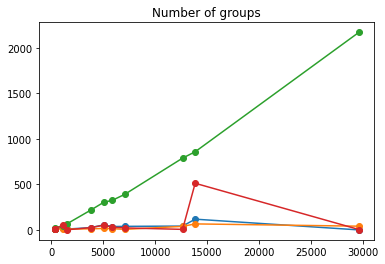

In [218]:
plt.plot(Network_info['N'],Size['SBM-DC'],"o-",label = "SBM")
plt.plot(Network_info['N'],Size['LOUVIAN'],"o-",label = "Louvian")
plt.plot(Network_info['N'],Size['INFOMAP'],"o-",label = "Infomap")
plt.plot(Network_info['N'],Size['SPECTRAL'],"o-",label = "Spectral")
plt.title('Number of groups')

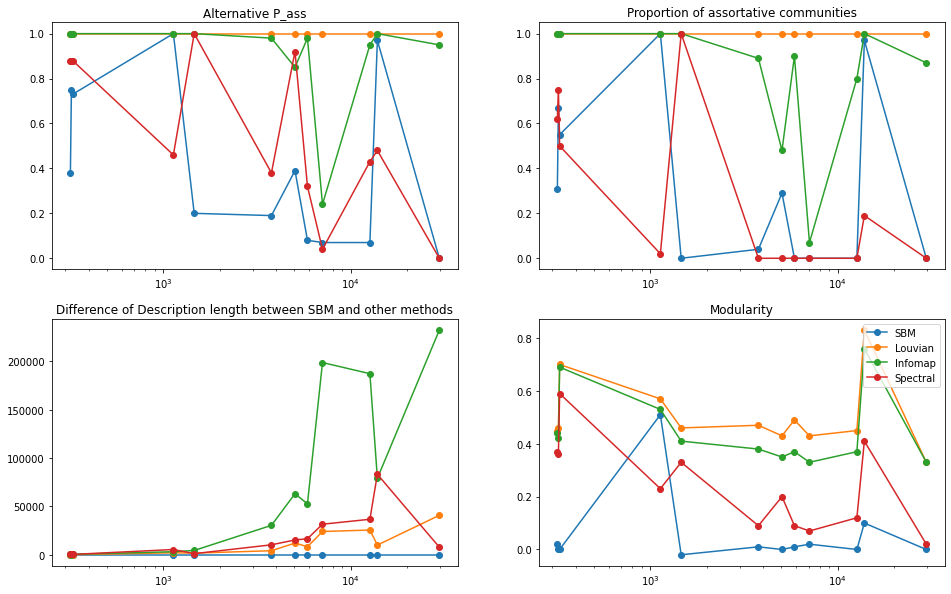

In [23]:
w = 16
h = 10
figure, axes = plt.subplots(2, 2,figsize=(w, h))

axes[0,0].plot(Network_info['N'],P_alt_ass['SBM-DC'],"o-",label = "SBM")
axes[0,0].plot(Network_info['N'],P_alt_ass['LOUVIAN'],"o-",label = "Louvian")
axes[0,0].plot(Network_info['N'],P_alt_ass['INFOMAP'],"o-",label = "Infomap")
axes[0,0].plot(Network_info['N'],P_alt_ass['SPECTRAL'],"o-",label = "Spectral")
axes[0,0].set_xscale('log')
axes[0,0].set_title('Alternative P_ass')

axes[0,1].plot(Network_info['N'],P_ass['SBM-DC'],"o-",label = "SBM")
axes[0,1].plot(Network_info['N'],P_ass['LOUVIAN'],"o-",label = "Louvian")
axes[0,1].plot(Network_info['N'],P_ass['INFOMAP'],"o-",label = "Infomap")
axes[0,1].plot(Network_info['N'],P_ass['SPECTRAL'],"o-",label = "Spectral")
axes[0,1].set_xscale('log')
axes[0,1].set_title('Proportion of assortative communities')

axes[1,0].plot(Network_info['N'],[0]*len(fnames),"o-",label = "SBM")
axes[1,0].plot(Network_info['N'],DL['LOUVIAN-SBM'],"o-",label = "Louvian")
axes[1,0].plot(Network_info['N'],DL['INFOMAP-SBM'],"o-",label = "Infomap")
axes[1,0].plot(Network_info['N'],DL['SPECTRAL-SBM'],"o-",label = "Spectral")
axes[1,0].set_xscale('log')
axes[1,0].set_title('Difference of Description length between SBM and other methods')

axes[1,1].plot(Network_info['N'],Mou['SBM-DC'],"o-",label = "SBM")
axes[1,1].plot(Network_info['N'],Mou['LOUVIAN'],"o-",label = "Louvian")
axes[1,1].plot(Network_info['N'],Mou['INFOMAP'],"o-",label = "Infomap")
axes[1,1].plot(Network_info['N'],Mou['SPECTRAL'],"o-",label = "Spectral")
axes[1,1].set_xscale('log')
axes[1,1].set_title('Modularity')

plt.legend(loc="upper right")
plt.show()

In [ ]:
#modularity for each community

In [23]:
SS.Alternative_Assortativity(d_spec),SS.statistics_Network_nonplot(d_spec)

(0.875, 0.625)

In [34]:
SS.Modularity(G_nx,SS.convert_par_to_iter(G_nx,sbm_dc_par))


[0.014213477279157644,
 0.03738706989482625,
 0.03588756971980421,
 0.02557723870115037,
 0.004151047872305159,
 0.04167462183140866,
 0.022121600957090037,
 0.006504405200872159,
 0.0009458274399487287,
 0.017332776884073284,
 0.05684078372583468,
 0.007374046478220384,
 0.011627548122141925,
 0.00037329116246235156,
 0.01333357127311007,
 0.00522023715831116,
 0.01551676127549317,
 0.014657796998734677,
 0.018231840912455628,
 0.012628939716459923,
 0.014126858113616815,
 0.04662602406234143,
 0.020242608713825792,
 0.04394847799482799,
 0.021216891327923048]

In [ ]:
#assortativeness

In [ ]:
#direction and degree 
#community size/number of links/nodes
#will ass prob vary with the num of community 
#diff network type
#spectral clustering - sophie's paper
#hirarchy 
#interpretation
#core-pheiphery classfication
#nature of data social network and other networks
#choose silimar num of nodes netowjrk

In [5]:
g = gt.collection.ns["amazon_copurchases/302"]
g.save("../Data/amazon_copurchases.xml.gz")

g = gt.collection.ns["bitcoin"]
g.save("../Data/bitcoin.xml.gz")

g = gt.collection.ns["faculty_hiring/computer_science"]
g.save("../Data/computer_science.xml.gz")

g = gt.collection.ns["faculty_hiring/business"]
g.save("../Data/business.xml.gz")

g = gt.collection.ns["faculty_hiring/history"]
g.save("../Data/history.xml.gz")

g = gt.collection.ns["un_migrations"]
g.save("../Data/un_migrations.xml.gz")

In [37]:
fnames =["business","history", "computer_science", "un_migrations"]

In [17]:
path_data = "../Data"
vp_name = "title"
ep_name = None

Network_info,Size,P_ass,DL,Mou =  SS.social_stats(path_data,fnames,SM = False)
with open("../Outputs/economic_stats.list","wb") as f:
    pickle.dump([Network_info,Size,P_ass,DL,Mou],f)



In [38]:
with open("../Outputs/economic_stats.list","rb") as f:
    Network_info,Size,P_ass,DL,Mou = pickle.load(f)

In [39]:
DL['LOUVIAN-SBM'],DL['INFOMAP-SBM'],DL['SPECTRAL-SBM']  = [],[],[]
for i in range(len(fnames)):
    P_ass['SBM'][i] = round(P_ass['SBM'][i],2)
    P_ass['LOUVIAN'][i] = round(P_ass['LOUVIAN'][i],2)
    P_ass['INFOMAP'][i] = round(P_ass['INFOMAP'][i],2)
    P_ass['SPECTRAL'][i] = round(P_ass['SPECTRAL'][i],2)
    DL['LOUVIAN-SBM'].append(round(DL['LOUVIAN'][i]-DL['SBM'][i],2))
    DL['INFOMAP-SBM'].append(round(DL['INFOMAP'][i]-DL['SBM'][i],2))
    DL['SPECTRAL-SBM'].append(round(DL['SPECTRAL'][i]-DL['SBM'][i],2))
    Mou['SBM'][i] = round(Mou['SBM'][i],2)
    Mou['LOUVIAN'][i] = round(Mou['LOUVIAN'][i],2)
    Mou['INFOMAP'][i] = round(Mou['INFOMAP'][i],2)
    Mou['SPECTRAL'][i] = round(Mou['SPECTRAL'][i],2)

In [40]:
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Network</b>','<b>N</b>','<b>E</b>','<b>Directed</b>','<b>Size(SBM)</b>','<b>Size(Louvian)</b>','<b>Size(Infomap)</b>','<b>Size(Spectral)</b>',\
            '<b>Assortative Prob(SBM)</b>','<b>Assortative Prob(Louvian)</b>','<b>Assortative Prob(Infomap)</b>','<b>Assortative Prob(Spectral)</b>',\
            '<b>Description Length(SBM)</b>','<b>Description Length(Louvian)</b>','<b>Description Length(Infomap)</b>','<b>Description Length(Spectral)</b>',\
            '<b>Modularity(SBM)</b>','<b>Modularity(Louvian)</b>','<b>Modularity(Infomap)</b>','<b>Modularity(Spectral)</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=11)
  ),
  cells=dict(
    values=[
      fnames,Network_info['N'],Network_info['E'],Network_info['Directed'],
        Size['SBM'],Size['LOUVIAN'],Size['INFOMAP'],Size['SPECTRAL'],
        P_ass['SBM'],P_ass['LOUVIAN'],P_ass['INFOMAP'],P_ass['SPECTRAL'],
        [0]*len(fnames), DL['LOUVIAN-SBM'],DL['INFOMAP-SBM'],DL['SPECTRAL-SBM'],
        Mou['SBM'],Mou['LOUVIAN'], Mou['INFOMAP'], Mou['SPECTRAL']],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor,rowEvenColor,rowOddColor,rowEvenColor,rowOddColor,rowEvenColor,rowOddColor]*10],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
],layout = go.Layout(
    autosize=False,
    width=1500,
    height=400))

fig.show()

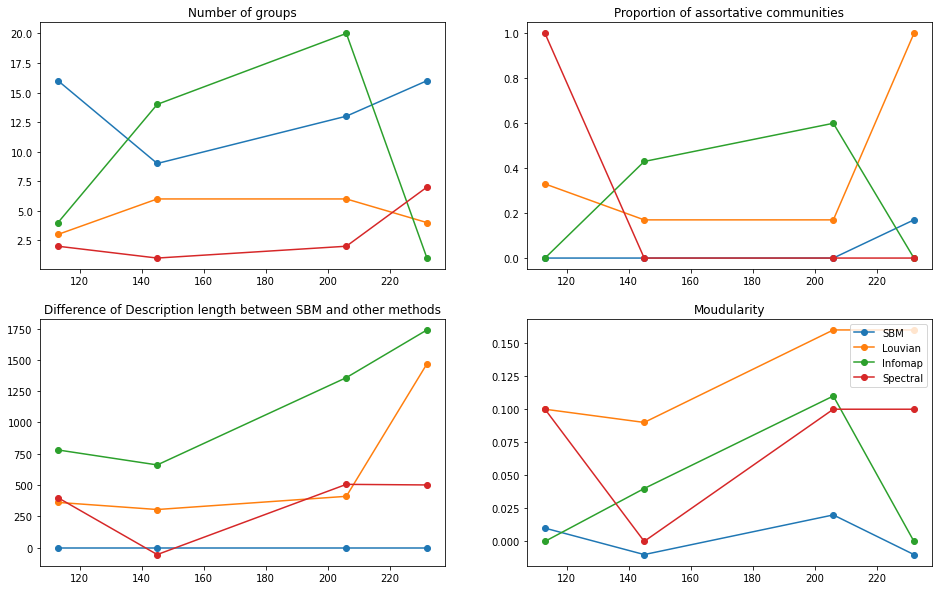

In [41]:
w = 16
h = 10
figure, axes = plt.subplots(2, 2,figsize=(w, h))

axes[0,0].plot(Network_info['N'],Size['SBM'],"o-",label = "SBM")
axes[0,0].plot(Network_info['N'],Size['LOUVIAN'],"o-",label = "Louvian")
axes[0,0].plot(Network_info['N'],Size['INFOMAP'],"o-",label = "Infomap")
axes[0,0].plot(Network_info['N'],Size['SPECTRAL'],"o-",label = "Spectral")
axes[0,0].set_title('Number of groups')

axes[0,1].plot(Network_info['N'],P_ass['SBM'],"o-",label = "SBM")
axes[0,1].plot(Network_info['N'],P_ass['LOUVIAN'],"o-",label = "Louvian")
axes[0,1].plot(Network_info['N'],P_ass['INFOMAP'],"o-",label = "Infomap")
axes[0,1].plot(Network_info['N'],P_ass['SPECTRAL'],"o-",label = "Spectral")
axes[0,1].set_title('Proportion of assortative communities')

axes[1,0].plot(Network_info['N'],[0]*len(fnames),"o-",label = "SBM")
axes[1,0].plot(Network_info['N'],DL['LOUVIAN-SBM'],"o-",label = "Louvian")
axes[1,0].plot(Network_info['N'],DL['INFOMAP-SBM'],"o-",label = "Infomap")
axes[1,0].plot(Network_info['N'],DL['SPECTRAL-SBM'],"o-",label = "Spectral")
axes[1,0].set_title('Difference of Description length between SBM and other methods')

axes[1,1].plot(Network_info['N'],Mou['SBM'],"o-",label = "SBM")
axes[1,1].plot(Network_info['N'],Mou['LOUVIAN'],"o-",label = "Louvian")
axes[1,1].plot(Network_info['N'],Mou['INFOMAP'],"o-",label = "Infomap")
axes[1,1].plot(Network_info['N'],Mou['SPECTRAL'],"o-",label = "Spectral")
axes[1,1].set_title('Moudularity')

plt.legend(loc="upper right")
plt.show()

## Case Study

In [6]:
fname = "Spiderman_par"
path_data = "../Data"
fname_data = fname + ".xml.gz"
filename = os.path.join(path_data,fname_data)
G_gt = gt.load_graph(filename)
G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(),counts = True, vp_name = "name",ep_name = "count")



In [31]:
print("Proportion of assortative communities")
print("SBM:",SS.statistics_Network_nonplot(d_sbm_dc))
print("Louvain:",SS.statistics_Network_nonplot(d_lou))
print("Infomap:",SS.statistics_Network_nonplot(d_info))

Proportion of assortative communities
SBM: 0.0
Louvain: 1.0
Infomap: 0.2442483454144343


In [32]:
print("Alternative Proportion of assortative communities")
print("SBM:",SS.Alternative_Assortativity(d_sbm_dc))
print("Louvain:",SS.Alternative_Assortativity(d_lou))
print("Infomap:",SS.Alternative_Assortativity(d_info))

Alternative Proportion of assortative communities
SBM: 0.14545454545454545
Louvain: 1.0
Infomap: 0.25827292782855343


In [34]:
print("DL")
print("SBM:",sbm_dc_state.entropy())
print("Louvain:",lou_state.entropy())
print("Infomap:",info_state.entropy())

DL
SBM: 1236866.6838691472
Louvain: 1258585.7348141018
Infomap: 2579545.9189942954


In [7]:
sbm_bs = []
state_arg = {}
if "count" in G_gt.ep:
    state_arg["eweight"] = G_gt.ep.count
state_arg['deg_corr'] = True
for i in range(10):
    gt.seed_rng(i)
    state = gt.minimize_blockmodel_dl(G_gt, state_args=state_arg)
    sbm_bs.append(list(state.get_blocks().get_array()))

In [8]:
lou_bs = []
for i in range(10):
    lou_bs.append(GM.Louvain_partition(G_nx,weight = 'weight',iteration = 1))

In [9]:
info_bs = []
for i in range(10):
    im = infomap.Infomap("--two-level")
    im.add_networkx_graph(G_nx)
    im.run()
    communities = im.get_modules()
    info_bs.append(list(communities.values()))

In [10]:
with open("../Outputs/Spiderman_sbm_bs.list","wb") as f:
    pickle.dump(sbm_bs,f)

In [11]:
with open("../Outputs/Spiderman_lou_bs.list","wb") as f:
    pickle.dump(lou_bs,f)

In [12]:
with open("../Outputs/Spiderman_info_bs.list","wb") as f:
    pickle.dump(info_bs,f)

## Case Study: Facebook friends

In [219]:
fname = "facebook_friends"
path_data = "../Data"
fname_data = fname + ".xml.gz"
filename = os.path.join(path_data,fname_data)
G_gt = gt.load_graph(filename)
G_nx = GM.convert_gt_to_nx(G_gt, vp_name = "title",ep_name = None)

In [66]:
with open("../Outputs/"+fname+"_sbm_dc.list","rb") as f:
    sbm_dc_par = pickle.load(f)

with open("../Outputs/"+fname+"_louvian.par","rb") as f:
    louvain_par = pickle.load(f)
with open("../Outputs/"+fname+"_info.list","rb") as f:
    info_par = pickle.load(f)
    
with open("../Outputs/"+fname+"_spectral.par","rb") as f:
    spec_par = pickle.load(f)

spec_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =spec_par) 

sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.title[n] for n in G_gt.vertices()],sbm_dc_par)

lou_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =louvain_par) 
    
info_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =info_par)  
#         DL['SBM'].append(sbm_state.entropy(degree_dl = False))
d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict)
d_lou = SS.get_density(G_gt,lou_par_dict)
d_info = SS.get_density(G_gt,info_par_dict)
d_spec = SS.get_density(G_gt,spec_par_dict)

In [67]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict)
SS.interaction_type_prob(d_sbm_dc,deg_list,directed = False)

{'U1': 0.7454545454545455, 'U2': 0.2, 'U5': 0.05454545454545454}

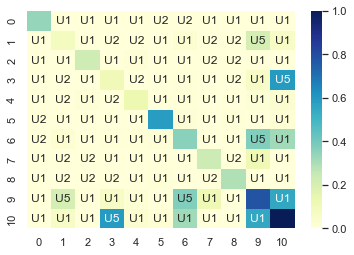

In [69]:
annot = SS.interaction_matrix(d_sbm_dc,deg_list,directed = False)
N,_ = annot.shape
# for i in range(N):
#     for j in range(N):
#         annot[i,j] = annot[i,j][0]
ax = sns.heatmap(d_sbm_dc,annot=annot,fmt = '', cmap="YlGnBu")

In [174]:
print(G_gt)

<Graph object, undirected, with 329 vertices and 1954 edges, 11 internal vertex properties, 2 internal edge properties, 5 internal graph properties, at 0x163f5c9a0>


In [29]:
pos = gt.sfdp_layout(G_gt)

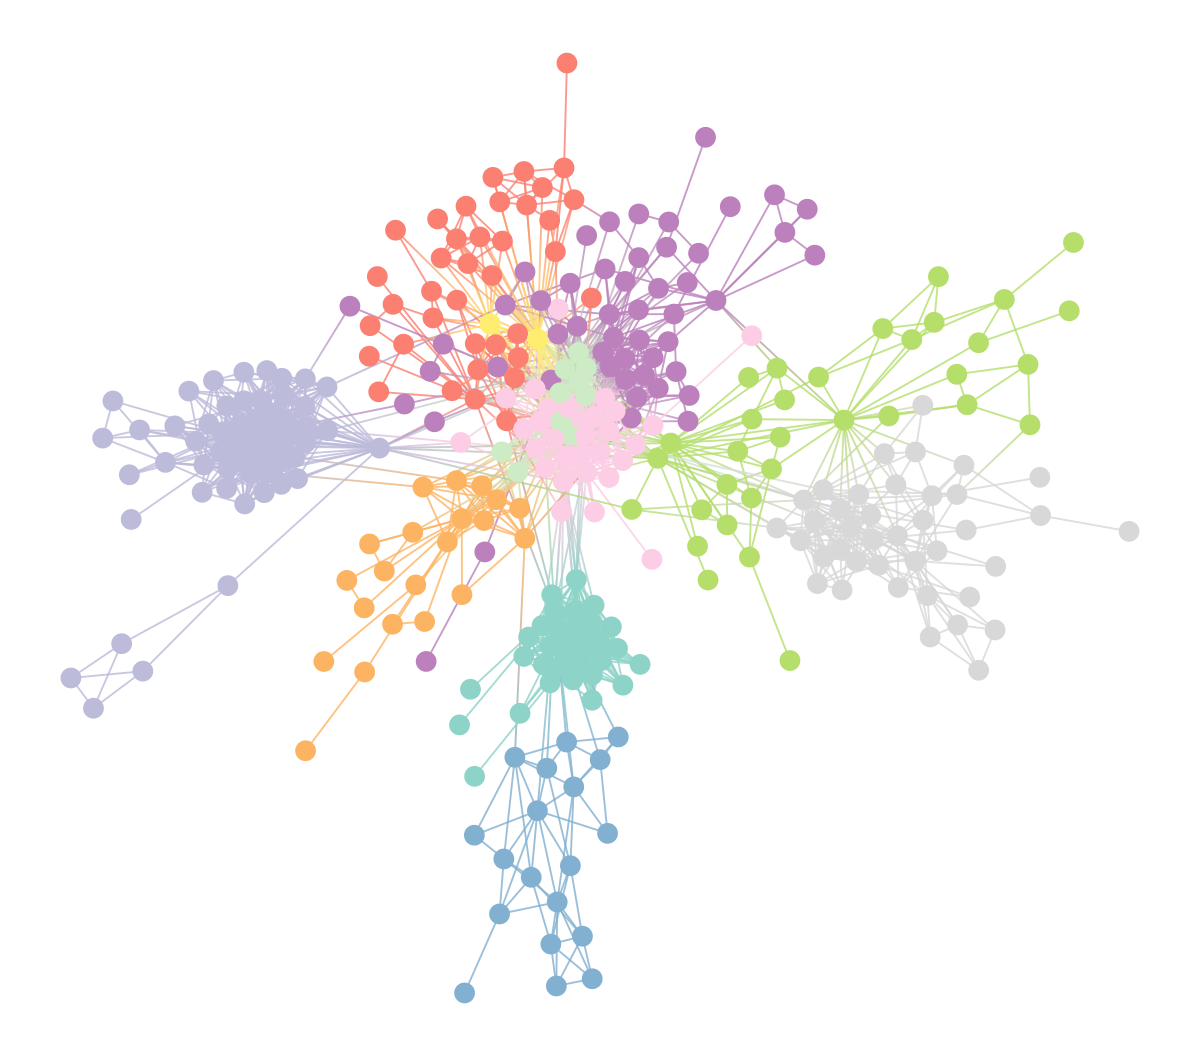

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16be0e340, at 0x16d1ac3d0>

In [30]:
sbm_dc_state.draw(pos = pos)

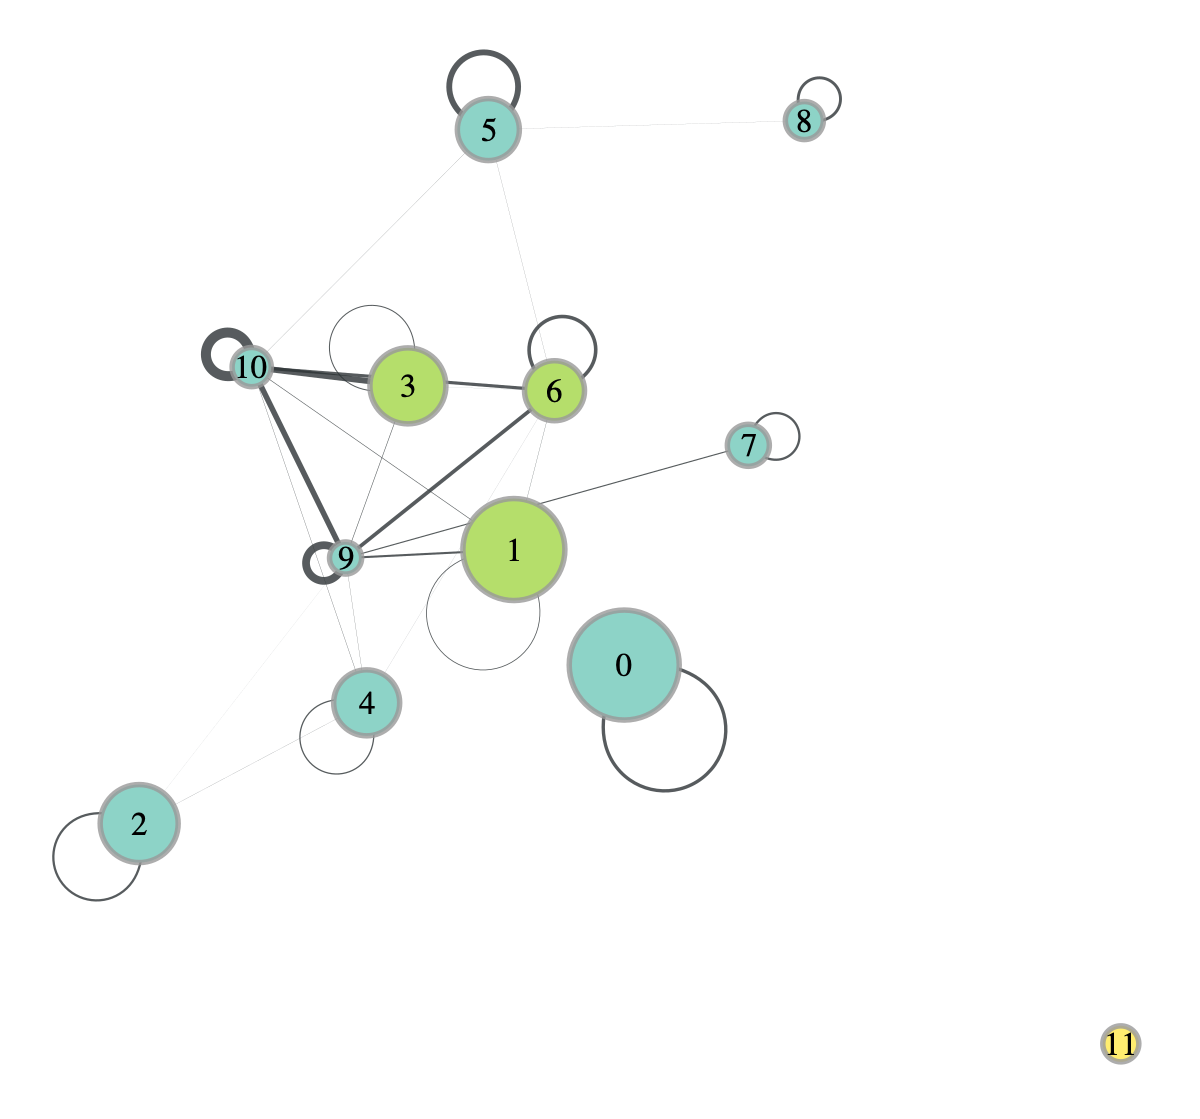

In [38]:
SS.plot_block_graph(G_gt,sbm_dc_state)

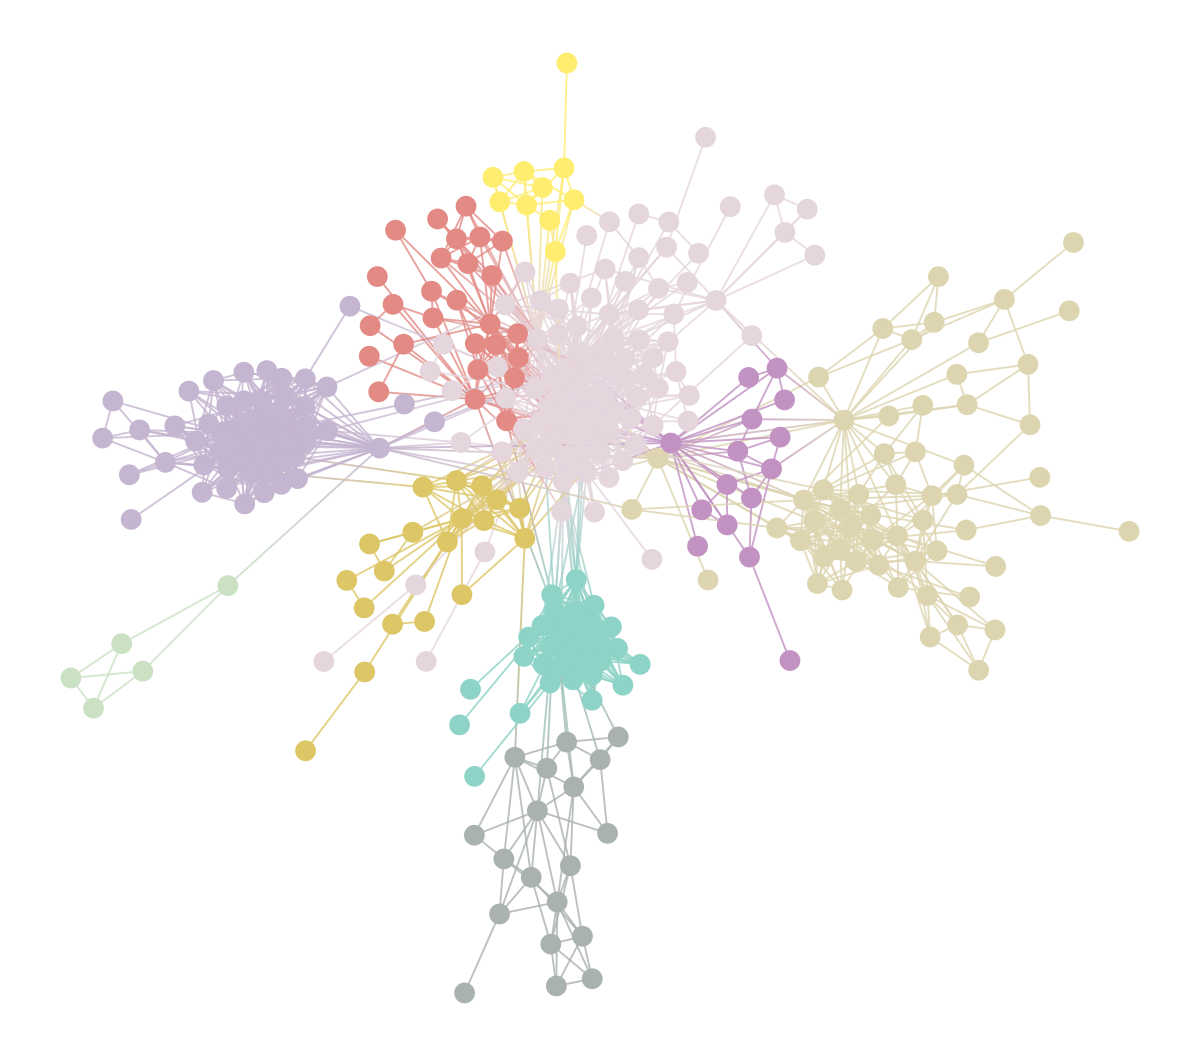

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16be0e340, at 0x16d1ac820>

In [31]:
lou_state.draw(pos = pos)

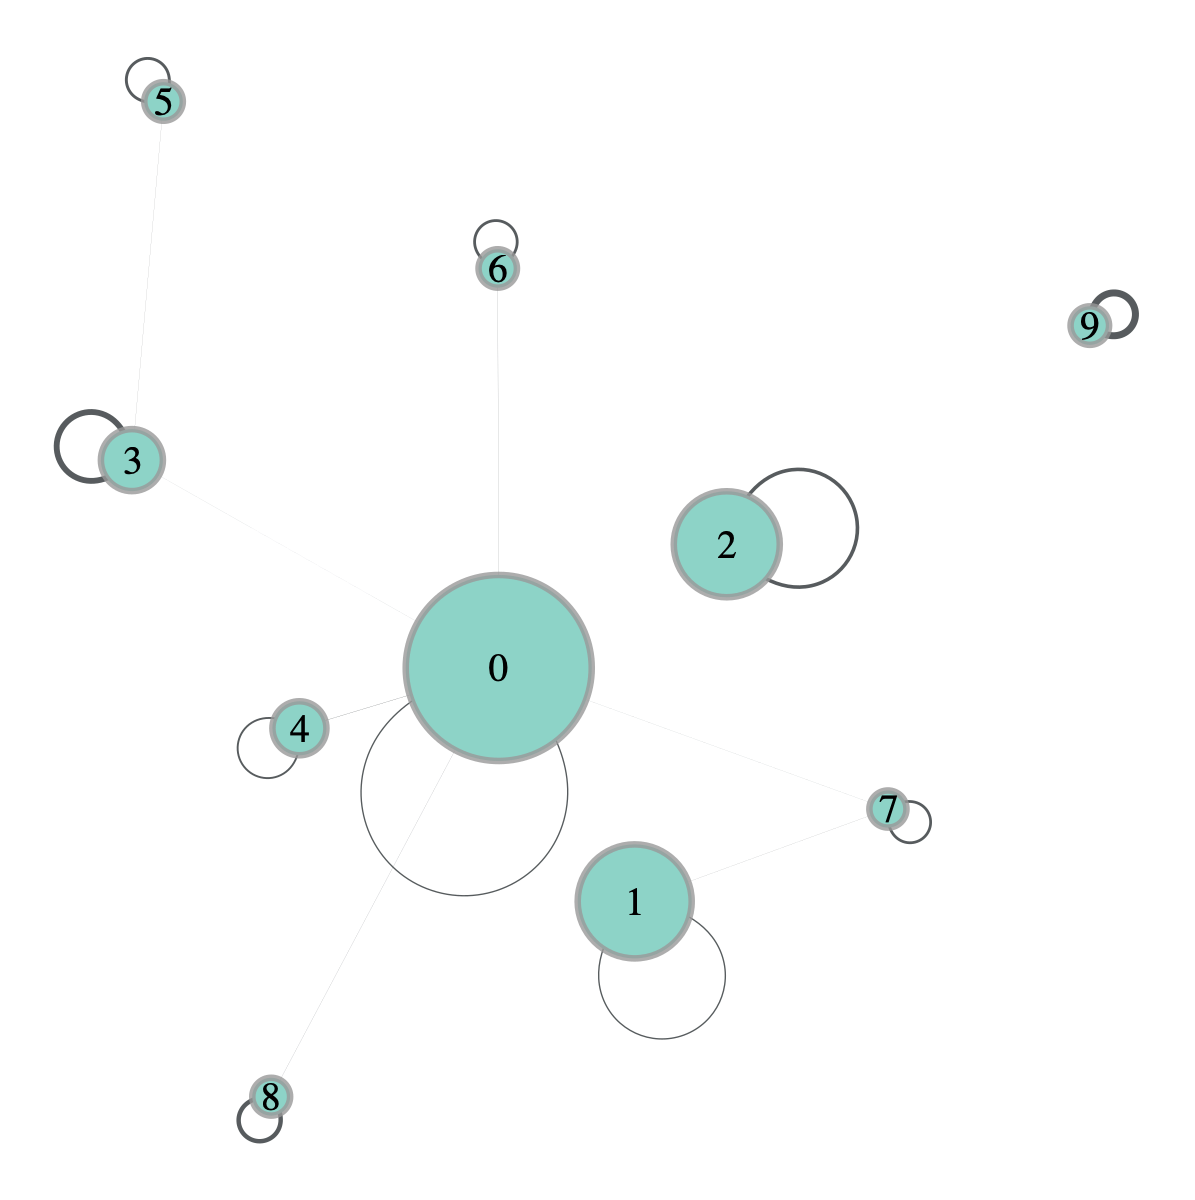

In [27]:
SS.plot_block_graph(G_gt,lou_state)

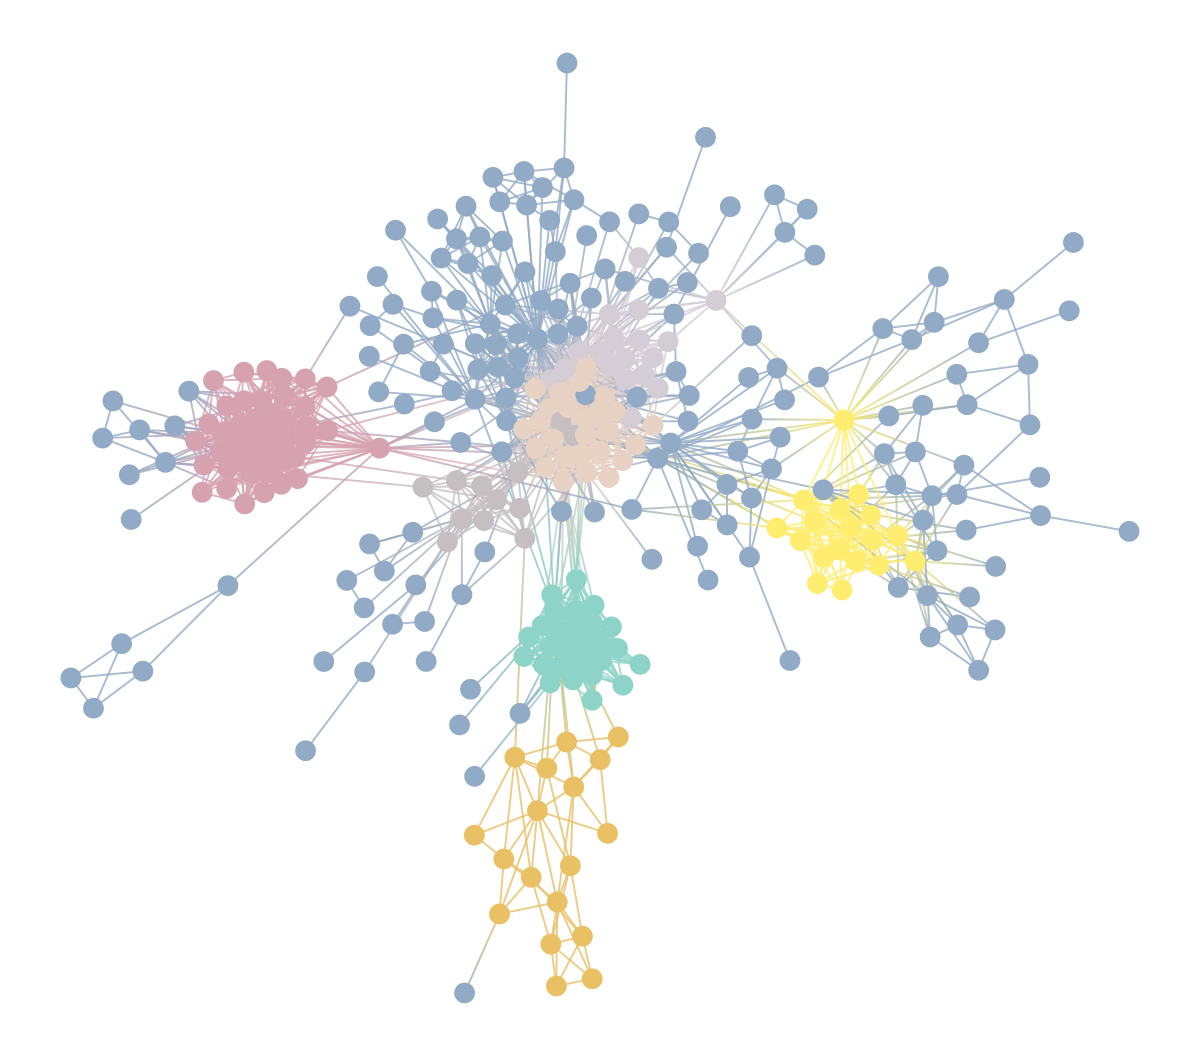

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16be0e340, at 0x16d1ac310>

In [32]:
spec_state.draw(pos = pos)

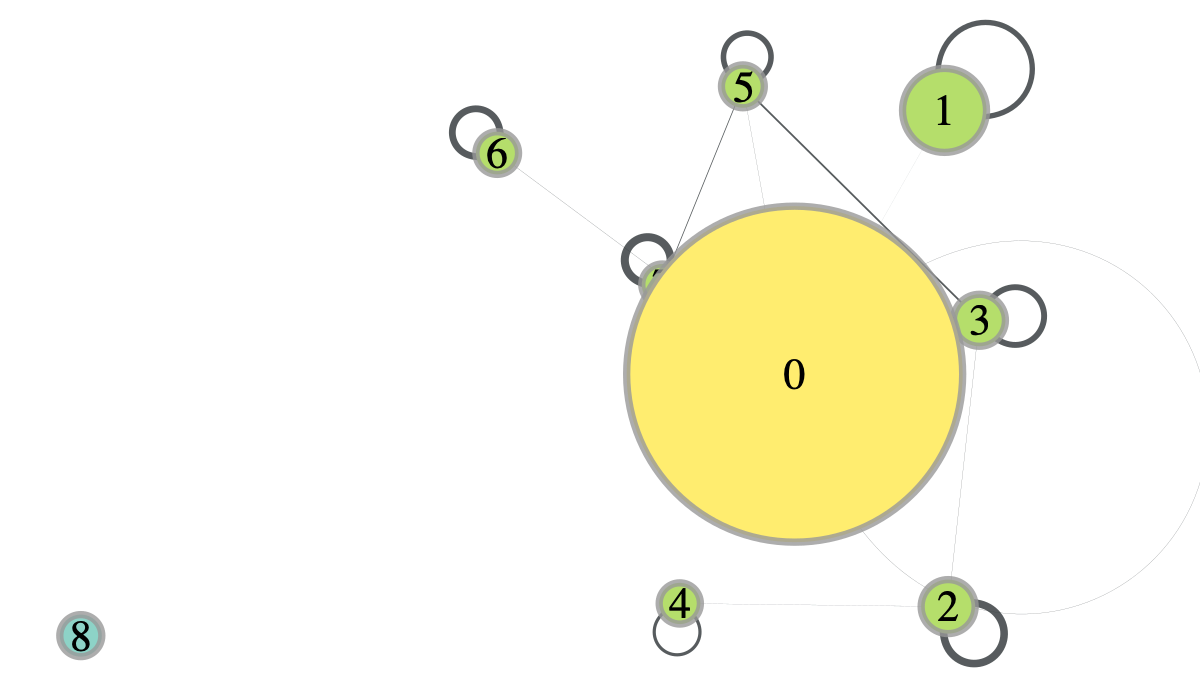

In [28]:
SS.plot_block_graph(G_gt,spec_state)

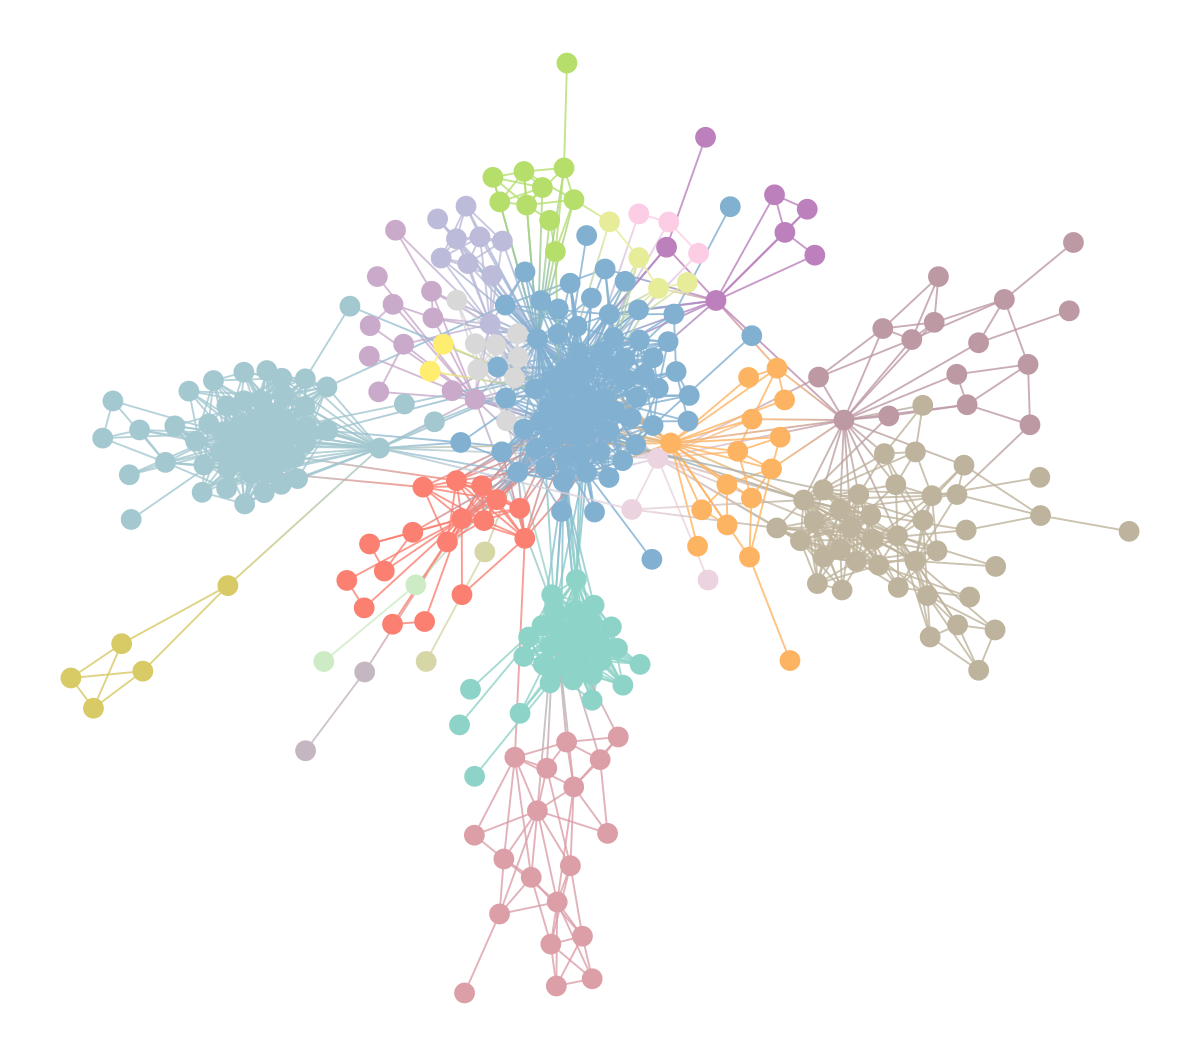

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16be0e340, at 0x16d1acc10>

In [33]:
info_state.draw(pos = pos)

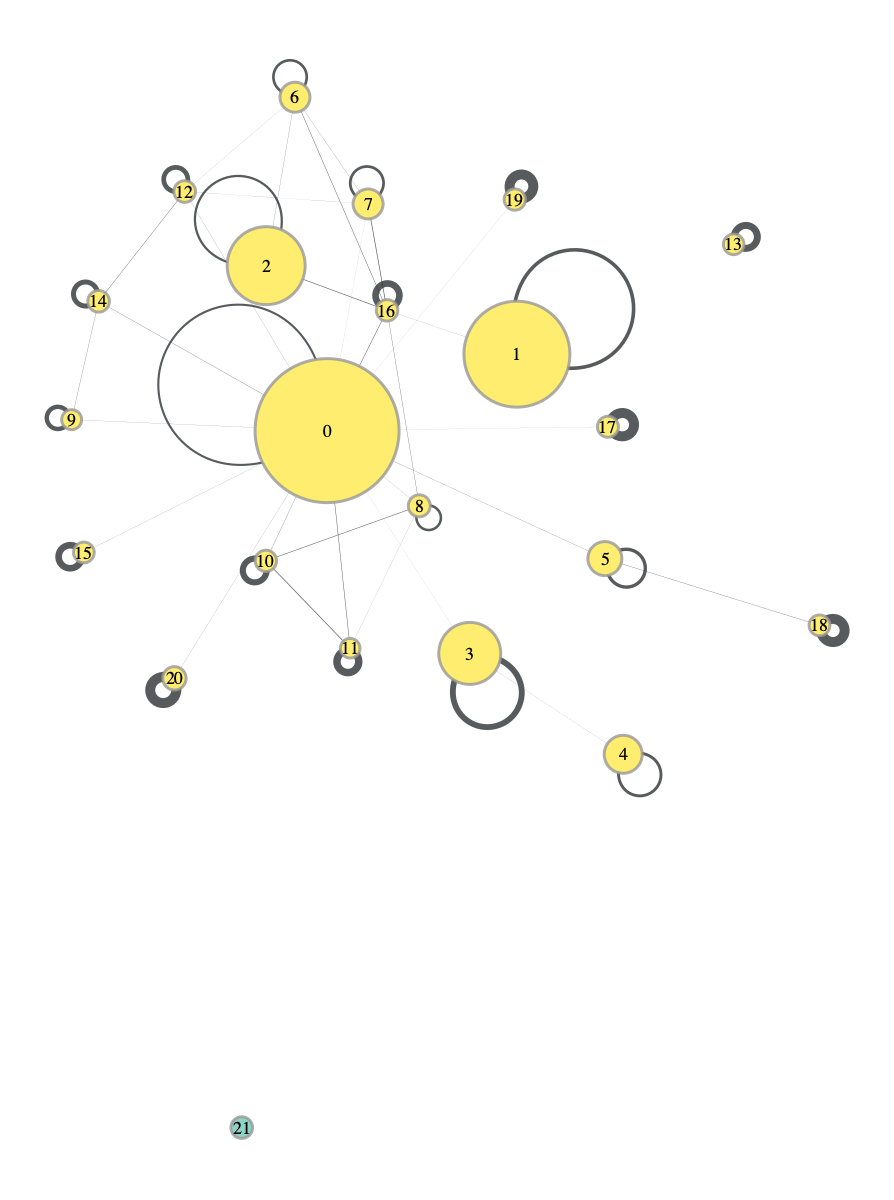

In [34]:
SS.plot_block_graph(G_gt,info_state)

In [14]:
print("Proportion of assortative communities")
print("SBM:",SS.statistics_Network_nonplot(d_sbm_dc))
print("Spectral:",SS.statistics_Network_nonplot(d_spec))
print("Louvain:",SS.statistics_Network_nonplot(d_lou))
print("Infomap:",SS.statistics_Network_nonplot(d_info))


Proportion of assortative communities
SBM: 0.5454545454545454
Spectral: 0.5
Louvain: 1.0
Infomap: 1.0


In [15]:
print("Proportion of assortative communities")
print("SBM:",SS.Alternative_Assortativity(d_sbm_dc))
print("Spectral:",SS.Alternative_Assortativity(d_spec))
print("Louvain:",SS.Alternative_Assortativity(d_lou))
print("Infomap:",SS.Alternative_Assortativity(d_info))

Proportion of assortative communities
SBM: 0.7272727272727273
Spectral: 0.875
Louvain: 1.0
Infomap: 1.0


In [11]:
%%time
sbm_bs = []
state_arg = {}
state_arg['deg_corr'] = True
for i in range(10):
    gt.seed_rng(i)
    state = gt.minimize_blockmodel_dl(G_gt, state_args=state_arg)
    sbm_bs.append(list(state.get_blocks().get_array()))

CPU times: user 550 ms, sys: 7.98 ms, total: 558 ms
Wall time: 572 ms


In [23]:
%%time
lou_bs = []
for i in range(10):
    lou_bs.append(GM.Louvain_partition(G_nx,iteration = 1)[0])

CPU times: user 385 ms, sys: 3.52 ms, total: 388 ms
Wall time: 388 ms


In [24]:
%%time
info_bs = []
for i in range(10):
    im = infomap.Infomap("--two-level")
    im.add_networkx_graph(G_nx)
    im.run()
    communities = im.get_modules()
    info_bs.append(list(communities.values()))

CPU times: user 1.35 s, sys: 137 ms, total: 1.48 s
Wall time: 114 ms


In [26]:
%%time
spec_bs = []
for i in range(10):
    spec_par = GM.Spectral_partition(G_nx,iteration = 1)
    spec_bs.append(spec_par)

CPU times: user 1.61 s, sys: 1.42 s, total: 3.03 s
Wall time: 21.1 s


In [27]:
with open("../Outputs/facebook_friends_sbm_bs.list","wb") as f:
    pickle.dump(sbm_bs,f)
    
with open("../Outputs/facebook_friends_lou_bs.list","wb") as f:
    pickle.dump(lou_bs,f)
    
with open("../Outputs/facebook_friends_info_bs.list","wb") as f:
    pickle.dump(info_bs,f)
    
with open("../Outputs/facebook_friends_spec_bs.list","wb") as f:
    pickle.dump(spec_bs,f)

In [50]:
print(SS.boostrap_pass(sbm_bs,G_gt,[G_gt.vp.title[n] for n in G_gt.vertices()],vp_name="title"))
print(SS.boostrap_pass(lou_bs,G_gt,[v for v in G_nx.nodes()],vp_name="title"))
print(SS.boostrap_pass(info_bs,G_gt,[v for v in G_nx.nodes()],vp_name="title"))
print(SS.boostrap_pass(spec_bs,G_gt,[v for v in G_nx.nodes()],vp_name="title"))

(0.4512391117654276, 0.3307519040010711, 0.5717263195297841)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(0.5, 0.5, 0.5)


In [185]:
SS.meta_majority(SS.meta_dist(G_gt,"sbm_dc","context_0"))

{0: ['school', 0.8727272727272727],
 1: ['uni', 0.6666666666666666],
 2: ['erasmus', 1.0],
 3: ['uni', 0.34210526315789475],
 4: ['erasmus', 0.8484848484848485],
 5: ['choir', 0.9032258064516129],
 6: ['uni', 0.8666666666666667],
 7: ['friend of exgf', 0.42857142857142855],
 8: ['studienstiftung', 0.6842105263157895],
 9: ['uni', 0.9],
 10: ['uni', 1.0]}

In [48]:
d = SS.meta_dist(G_gt,"spec","context_0")
for k in d.keys():
    for k2 in d[k].keys():
        if d[k][k2] != 0:
            print(k,k2,d[k][k2])

0 awkward connections 1
0 choir 1
0 climbing 2
0 dortmund 4
0 erasmus 55
0 exgf 1
0 family 3
0 family friend 2
0 friend of exgf 18
0 friend of friend 2
0 gf 1
0 hong kong 6
0 hongkong 3
0 munich 2
0 physics conference 2
0 quitte 6
0 random 5
0 school 8
0 studienstiftung 3
0 uni 42
0 xrays 1
1 exgf 1
1 school 41
2 choir 27
3 exgf 1
3 uni 25
4 barcelona 1
4 french class 5
4 studienstiftung 12
5 erasmus 1
5 exgf 1
5 uni 16
6 erasmus 18
7 exgf 1
7 friend of exgf 1
7 studienstiftung 7
7 uni 3


In [46]:
type(d[0])

dict

In [197]:
SS.meta_majority(SS.meta_dist(G_gt,"louvian","context_0"))

{0: ['uni', 0.7849462365591398],
 1: ['erasmus', 1.0],
 2: ['school', 0.9245283018867925],
 3: ['choir', 0.9032258064516129],
 4: ['uni', 0.48148148148148145],
 5: ['studienstiftung', 0.6842105263157895],
 6: ['friend of exgf', 0.47368421052631576],
 7: ['erasmus', 0.6666666666666666],
 8: ['hong kong', 0.6],
 9: ['family', 0.6]}

In [36]:
SS.meta_majority(SS.meta_dist(G_gt,"spec","context_0"))

{0: ['erasmus', 0.3273809523809524],
 1: ['school', 0.9761904761904762],
 2: ['choir', 1.0],
 3: ['uni', 0.9615384615384616],
 4: ['studienstiftung', 0.6666666666666666],
 5: ['uni', 0.8888888888888888],
 6: ['erasmus', 1.0],
 7: ['studienstiftung', 0.5833333333333334]}

In [37]:
SS.meta_majority(SS.meta_dist(G_gt,"info","context_0"))

{0: ['uni', 0.8888888888888888],
 1: ['school', 0.9245283018867925],
 2: ['erasmus', 1.0],
 3: ['choir', 0.9032258064516129],
 4: ['studienstiftung', 0.6842105263157895],
 5: ['friend of exgf', 0.5294117647058824],
 6: ['erasmus', 1.0],
 7: ['erasmus', 0.6666666666666666],
 8: ['friend of exgf', 0.5454545454545454],
 9: ['hong kong', 0.6],
 10: ['quitte', 0.6666666666666666],
 11: ['uni', 1.0],
 12: ['erasmus', 0.7142857142857143],
 13: ['family', 0.6],
 14: ['uni', 0.75],
 15: ['uni', 1.0],
 16: ['erasmus', 1.0],
 17: ['munich', 1.0],
 18: ['studienstiftung', 1.0],
 19: ['uni', 1.0],
 20: ['random', 1.0]}

In [201]:
SS.meta_majority(SS.meta_dist(G_gt,"context_0","sbm_dc"))

{0: [8, 0.3953488372093023],
 1: [7, 0.527027027027027],
 2: [0, 0.9795918367346939],
 3: [1, 1.0],
 4: [3, 0.5909090909090909],
 5: [4, 0.47368421052631576],
 6: [2, 1.0],
 7: [2, 1.0],
 8: [1, 0.4],
 9: [0, 0.2],
 10: [3, 1.0],
 11: [5, 1.0],
 12: [0, 1.0],
 13: [2, 1.0],
 14: [2, 0.5],
 15: [8, 1.0],
 16: [8, 1.0],
 17: [1, 0.5],
 18: [0, 1.0],
 19: [8, 1.0],
 20: [6, 1.0],
 21: [8, 1.0],
 22: [3, 1.0]}

## Case Study: Climate retweeting

In [97]:
G_gt = gt.load_graph("../Data/Climate.xml.gz")
print(G_gt)

<Graph object, directed, with 4029 vertices and 429235 edges, 1 internal vertex property, 1 internal edge property, at 0x17ea31970>


In [99]:
G_gt.ep

{'count': <EdgePropertyMap object with value type 'int32_t', for Graph 0x17ea31970, at 0x17e6b9d60>}

In [75]:
G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(), vp_name = "name",ep_name = None)

In [76]:
with open("../Outputs/climate_sbm.list", "rb") as fp:
    sbm_nested_par = pickle.load(fp)
with open("../Outputs/climate_louvian.par", "rb") as fp:
    louvain_par = pickle.load(fp)
with open("../Outputs/climate_info.list", "rb") as fp:
    info_par = pickle.load(fp)

In [77]:
state = gt.NestedBlockState(G_gt,sbm_nested_par)
sbm_par = state.project_partition(5, 0).get_array()

In [54]:
%%time
vp_name = "name"
ep_name = None
G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(),counts = False,vp_name = vp_name,ep_name = ep_name)
    
louvain_par = GM.Louvain_partition(G_nx,iteration = 1)
    
with open("climate_louvian.par","wb") as f:
    pickle.dump(louvain_par,f)

CPU times: user 8.5 s, sys: 132 ms, total: 8.63 s
Wall time: 8.65 s


In [55]:
im = infomap.Infomap("--two-level")
im.add_networkx_graph(G_nx)
im.run()
communities = im.get_modules()

with open("climate_info.list","wb") as f:
    pickle.dump(list(communities.values()),f)

In [78]:
sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")

lou_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =louvain_par[0],vp_name = "name") 
    
info_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =info_par,vp_name = "name")   

d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "count")
d_lou = SS.get_density(G_gt,lou_par_dict, ep_name = "count")
d_info = SS.get_density(G_gt,info_par_dict, ep_name = "count")

In [81]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "count")
SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True)

{'D1': 0.16666666666666666,
 'D2': 0.3333333333333333,
 'D3': 0.2222222222222222,
 'D4': 0.2777777777777778}

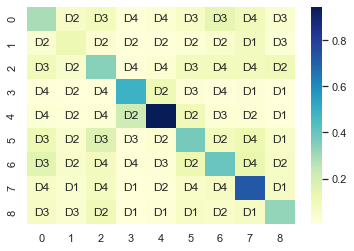

In [83]:
annot = SS.interaction_matrix(d_sbm_dc,deg_list,directed = True)
N,_ = annot.shape
# for i in range(N):
#     for j in range(N):
#         annot[i,j] = annot[i,j][0]
ax = sns.heatmap(d_sbm_dc,annot=annot,fmt = '', cmap="YlGnBu")

In [ ]:
#reply network

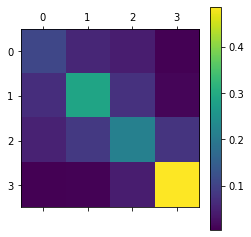

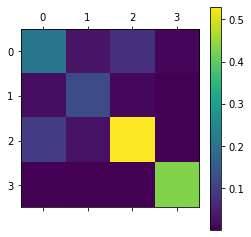

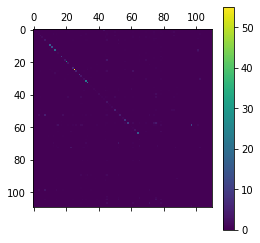

In [22]:
plt.matshow(d_sbm_dc) #eij/(ni*nj)
plt.colorbar()
plt.matshow(d_lou) #eij/(ni*nj)
plt.colorbar()
plt.matshow(d_info) #eij/(ni*nj)
plt.colorbar()

In [23]:
print("Proportion of assortative communities")
print("SBM:",SS.statistics_Network_nonplot(d_sbm_dc))
print("Louvain:",SS.statistics_Network_nonplot(d_lou))
print("Infomap:",SS.statistics_Network_nonplot(d_info))

Proportion of assortative communities
SBM: 1.0
Louvain: 1.0
Infomap: 0.1


In [24]:
print("Proportion of assortative communities")
print("SBM:",SS.Alternative_Assortativity(d_sbm_dc))
print("Louvain:",SS.Alternative_Assortativity(d_lou))
print("Infomap:",SS.Alternative_Assortativity(d_info))

Proportion of assortative communities
SBM: 1.0
Louvain: 1.0
Infomap: 0.3181818181818182


In [25]:
%%time
sbm_bs = []
state_arg = {}
state_arg['deg_corr'] = True
state_arg["eweight"] = G_gt.ep.count
for i in range(10):
    gt.seed_rng(i)
    state = gt.minimize_blockmodel_dl(G_gt, state_args=state_arg)
    sbm_bs.append(list(state.get_blocks().get_array()))

CPU times: user 24min 55s, sys: 2min 2s, total: 26min 58s
Wall time: 26min 59s


In [26]:
%%time
lou_bs = []
for i in range(10):
    lou_bs.append(GM.Louvain_partition(G_nx,iteration = 1)[0])

CPU times: user 1min 12s, sys: 834 ms, total: 1min 13s
Wall time: 1min 13s


In [27]:
%%time
info_bs = []
for i in range(10):
    im = infomap.Infomap("--two-level")
    im.add_networkx_graph(G_nx)
    im.run()
    communities = im.get_modules()
    info_bs.append(list(communities.values()))

CPU times: user 39.3 s, sys: 3 s, total: 42.3 s
Wall time: 14.8 s


In [28]:
with open("../Outputs/climate_sbm_bs.list","wb") as f:
    pickle.dump(sbm_bs,f)
    
with open("../Outputs/climate_lou_bs.list","wb") as f:
    pickle.dump(lou_bs,f)
    
with open("../Outputs/climate_info_bs.list","wb") as f:
    pickle.dump(info_bs,f)

In [30]:
print(SS.boostrap_pass(sbm_bs,G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],vp_name="name"))
print(SS.boostrap_pass(lou_bs,G_gt,[v for v in G_nx.nodes()],vp_name="name"))
print(SS.boostrap_pass(info_bs,G_gt,[v for v in G_nx.nodes()],vp_name="name"))

(0.000824996628505317, -0.00045651771019911353, 0.0021065109672097474)
(1.0, 1.0, 1.0)
(0.10909090909090909, 0.10909090909090909, 0.10909090909090909)


## Climate Reply

In [65]:
G_gt = gt.load_graph("../Data/Climatereply.xml.gz")
print(G_gt)

<Graph object, directed, with 3954 vertices and 233336 edges, 1 internal vertex property, 1 internal edge property, at 0x178cb6e20>


In [66]:
G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(), vp_name = "name",ep_name = "count")

In [67]:
with open("../Outputs/Climatereply_sbm.par", "rb") as fp:
    sbm_nested_par = pickle.load(fp)

In [71]:
state = gt.NestedBlockState(G_gt,sbm_nested_par)
sbm_par = state.project_partition(4, 0).get_array()

sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")  
d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "count")

deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "count")
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True))
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

{'D1': 0.17857142857142858, 'D11': 0.03571428571428571, 'D13': 0.03571428571428571, 'D14': 0.03571428571428571, 'D2': 0.39285714285714285, 'D3': 0.17857142857142858, 'D4': 0.10714285714285714, 'D9': 0.03571428571428571}
{'Assortative': 0.8571428571428571, 'Core-Periphery': 0.14285714285714285}


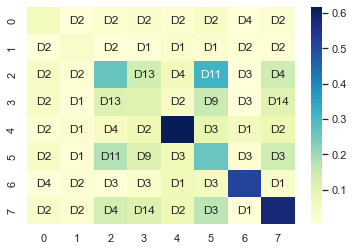

In [72]:
annot = SS.interaction_matrix(d_sbm_dc,deg_list,directed = True)
N,_ = annot.shape
ax = sns.heatmap(d_sbm_dc,annot=annot,fmt = '', cmap="YlGnBu")

## Slovenian Retweet

In [244]:
df = pd.read_csv('../Data/clarin_plos/clarin_plos_15072021.csv')

In [7]:
df.head()

date            tweet_id  user_id  retweeted_tweet_id  \
0  2018-01-01  947841329228337152    10841                 NaN   
1  2018-01-01  947875116297392129    20996                 NaN   
2  2018-01-01  947974115578798083    16022        9.478590e+17   
3  2018-01-01  947859017887551490     7901        9.478501e+17   
4  2018-01-01  947935056709996545    17655                 NaN   

   retweeted_user_id  hate_label  
0                NaN         0.0  
1                NaN         0.0  
2            14117.0         NaN  
3             5157.0         NaN  
4                NaN         0.0

In [245]:
#generate a {node:neighbors}/{tweet user:retweeted user} dict
node_dict = {}
count_row = df.shape[0]

for i in range(count_row):
    row = df.iloc[i]
    if not np.isnan(row['retweeted_user_id']):
        source = str(row['retweeted_user_id'])
        target = str(row['user_id'])
        if target in node_dict.keys():
            node_dict[target].append(source)
        else:
            node_dict[target] = [source]

In [246]:
G0 = make_graph(node_dict)
G1 = make_graph(node_dict,directed = True)

In [247]:
#extract largest component in G0
Gcc = gt.extract_largest_component(G0, prune = True)
#remove self-loops
gt.remove_self_loops(Gcc)

#keep same nodes as G0
G_users = [Gcc.vp.name[n] for n in Gcc.vertices()]
vlist = G1.vertices()
for n in reversed(sorted(vlist)):
    if G1.vp.name[n] not in G_users:
        G1.remove_vertex(n)
gt.remove_self_loops(G1)

G_gt = G1

In [248]:
G_gt.save("../Data/Slovenian.xml.gz")

In [249]:
G_gt = gt.load_graph("../Data/Slovenian.xml.gz")

In [250]:
print(G_gt)

<Graph object, directed, with 25697 vertices and 1053336 edges, 1 internal vertex property, 1 internal edge property, at 0x1790643d0>


In [85]:
G_nx = SS.convert_gt_to_nx(G_gt,directed = G_gt.is_directed(), vp_name = "name",ep_name = "count")

In [36]:
%%time
louvain_par = GM.Louvain_partition(G_nx,iteration = 1)

with open("../Outputs/Slovenian_louvian.par","wb") as f:
    pickle.dump(louvain_par,f)

CPU times: user 32.3 s, sys: 266 ms, total: 32.6 s
Wall time: 32.6 s


In [42]:
%%time
im = infomap.Infomap("--two-level")
im.add_networkx_graph(G_nx)
im.run()
communities = im.get_modules()

with open("../Outputs/Slovenian_info.list","wb") as f:
    pickle.dump(list(communities.values()),f)

CPU times: user 16.9 s, sys: 283 ms, total: 17.1 s
Wall time: 14.2 s


In [86]:
with open("../Outputs/Slovenian_sbm_dc.list", "rb") as fp:
    sbm_par = pickle.load(fp)
with open("../Outputs/Slovenian_info.list", "rb") as fp:
    info_par = pickle.load(fp)
with open("../Outputs/Slovenian_louvian.par","rb") as fp:
    louvain_par = pickle.load(fp)

In [87]:
sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")

lou_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =louvain_par[0],vp_name = "name") 
    
info_par_dict = SS.get_par_dict(G_gt,node_order=[v for v in G_nx.nodes()],par =info_par,vp_name = "name")   

d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "count")
d_lou = SS.get_density(G_gt,lou_par_dict, ep_name = "count")
d_info = SS.get_density(G_gt,info_par_dict, ep_name = "count")

In [54]:
print(len(set(sbm_par)))
print(len(set(info_par)))
print(len(set(louvain_par[0])))

458
9464
81


In [ ]:
#summeise by community/all paires

In [92]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "count")
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True))
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

{'D1': 0.18131348360773222, 'D11': 0.11581130020161869, 'D13': 0.12727776556811557, 'D14': 0.042913246634114645, 'D15': 0.006774769954038585, 'D17': 0.04492943346105702, 'D18': 0.014199306278845327, 'D19': 0.014992403466694696, 'D2': 0.00891517682245134, 'D20': 0.0048350262295395255, 'D21': 0.05399749648839498, 'D22': 0.009794272500549435, 'D23': 0.012211785615319198, 'D24': 0.003841265897776461, 'D3': 0.03594736892396778, 'D4': 0.0033730518953111713, 'D5': 0.06489063858656703, 'D6': 0.011638462346994352, 'D7': 0.06132647893514758, 'D8': 0.010147821849349755, 'D9': 0.17086944473641463}
{'Assortative': 0.22954908124946252, 'Core-Periphery': 0.6224475170324788, 'Disassortative': 0.14800340171805873}


In [37]:
annot = SS.exact_interaction_types(d_sbm_dc,deg_list,directed = True)

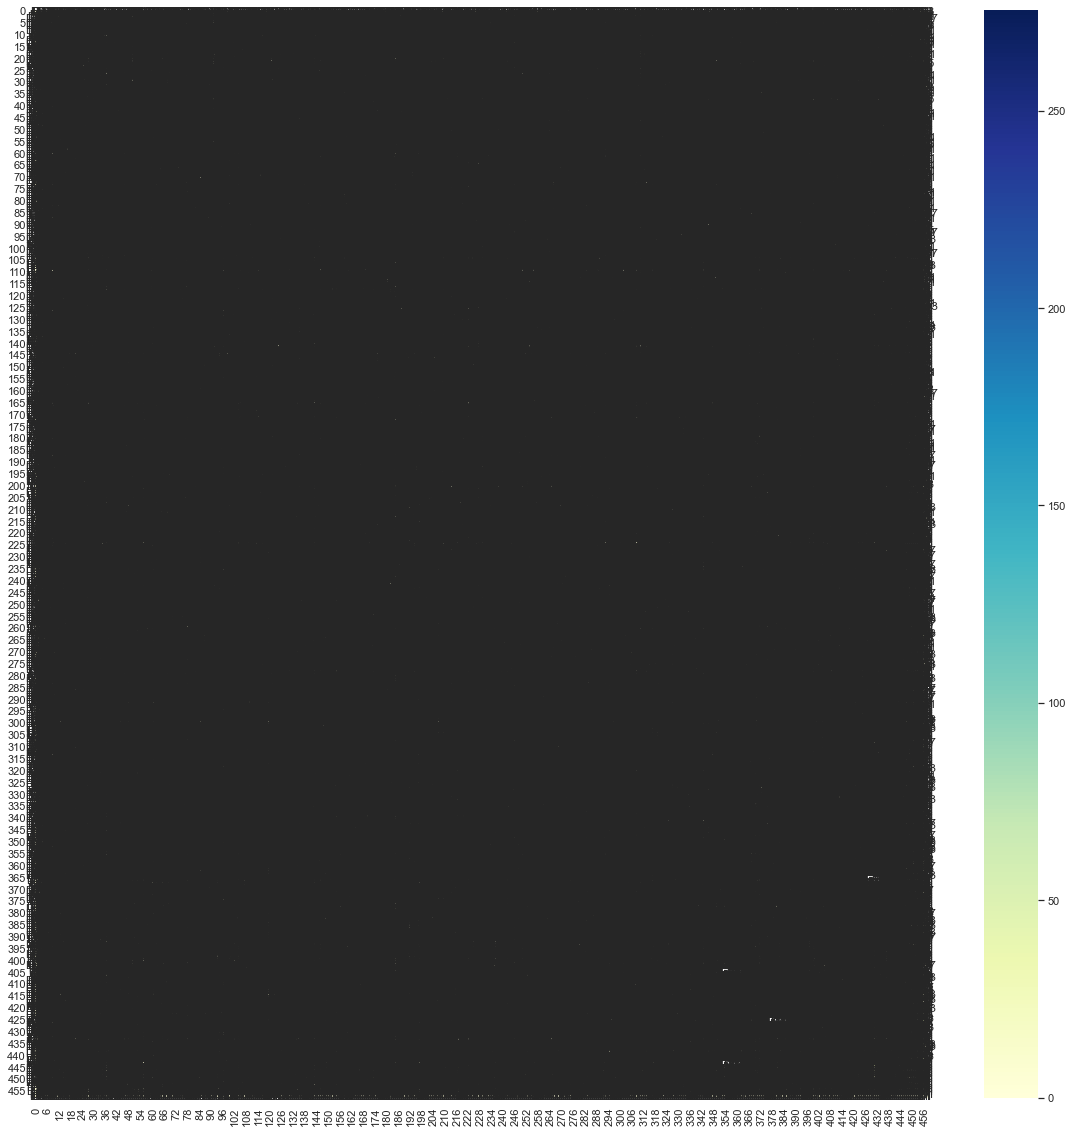

In [39]:
plt.figure(figsize = (20,20))
ax = sns.heatmap(d_sbm_dc,annot=annot,fmt = '', cmap="YlGnBu")

In [46]:
print("Proportion of assortative communities")
print("SBM:",SS.statistics_Network_nonplot(d_sbm_dc))
print("Louvain:",SS.statistics_Network_nonplot(d_lou))
print("Infomap:",SS.statistics_Network_nonplot(d_info))



Proportion of assortative communities
SBM: 0.0
Louvain: 0.9506172839506173
Infomap: 0.013947590870667794


In [47]:
print("Proportion of assortative communities")
print("SBM:",SS.Alternative_Assortativity(d_sbm_dc))
print("Louvain:",SS.Alternative_Assortativity(d_lou))
print("Infomap:",SS.Alternative_Assortativity(d_info))

Proportion of assortative communities
SBM: 0.0
Louvain: 0.9753086419753086
Infomap: 0.0790363482671175


## Case Study: NYClimate

In [254]:
G_gt = gt.load_graph("../Data/NYClimate.xml.gz")
with open("../Outputs/NYClimate_sbm_dc.list", "rb") as fp:
    sbm_par = pickle.load(fp)
print(G_gt)

<Graph object, directed, with 3336 vertices and 22245 edges, 2 internal vertex properties, 1 internal edge property, at 0x179592040>


In [226]:
sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")
d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "weight")

In [227]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "weight")
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True))
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

{'D1': 0.35346938775510206, 'D11': 0.031020408163265307, 'D13': 0.02040816326530612, 'D14': 0.004897959183673469, 'D15': 0.004081632653061225, 'D17': 0.0008163265306122449, 'D19': 0.02122448979591837, 'D2': 0.14204081632653062, 'D21': 0.005714285714285714, 'D23': 0.03918367346938775, 'D3': 0.21224489795918366, 'D4': 0.05877551020408163, 'D5': 0.0008163265306122449, 'D6': 0.0024489795918367346, 'D7': 0.0032653061224489797, 'D8': 0.0008163265306122449, 'D9': 0.09877551020408164}
{'Assortative': 0.7665306122448979, 'Core-Periphery': 0.22612244897959183, 'Disassortative': 0.007346938775510204}


In [232]:
df = pd.concat([df,pd.DataFrame(['NYClimate'],columns = ['Name'])],ignore_index=True)

In [237]:
df = df.astype('object')

In [238]:
df.at[1,'Interaction Fraction-SBM'] = SS.interaction_type_prob(d_sbm_dc,deg_list,directed = G_gt.is_directed(),classification ="Three")

In [240]:
df['Interaction Fraction-SBM'] 

0                                                  NaN
1    {'Assortative': 0.7665306122448979, 'Core-Peri...
Name: Interaction Fraction-SBM, dtype: object

## Case Study: Moscow

In [110]:
G_gt = gt.load_graph("../Data/Moscow.xml.gz")
with open("../Outputs/Moscow_sbm_dc.list", "rb") as fp:
    sbm_par = pickle.load(fp)
print(G_gt)

<Graph object, directed, with 1564 vertices and 7316 edges, 1 internal vertex property, 1 internal edge property, at 0x17ddfd250>


In [111]:
sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")
d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "weight")

In [112]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "weight")
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True))
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

{'D1': 0.21978021978021978, 'D14': 0.01098901098901099, 'D2': 0.27472527472527475, 'D3': 0.23076923076923078, 'D4': 0.12087912087912088, 'D9': 0.14285714285714285}
{'Assortative': 0.8461538461538461, 'Core-Periphery': 0.15384615384615385}


## Case Study: MLKing

In [120]:
G_gt = gt.load_graph("../Data/MLKing.xml.gz")
with open("../Outputs/MLKing_sbm_dc.list", "rb") as fp:
    sbm_par = pickle.load(fp)
print(G_gt)

<Graph object, directed, with 18 vertices and 34 edges, 1 internal vertex property, 1 internal edge property, at 0x17f3c9fd0>


In [121]:
sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")
d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "weight")

In [122]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "weight")
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True))
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

{'D6': 1.0}
{'Disassortative': 1.0}


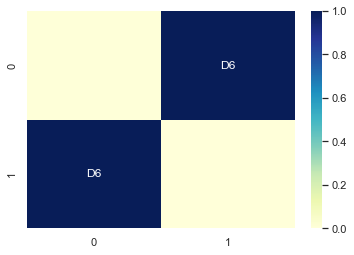

In [123]:
annot = SS.interaction_matrix(d_sbm_dc,deg_list,directed = True)
N,_ = annot.shape
ax = sns.heatmap(d_sbm_dc,annot=annot,fmt = '', cmap="YlGnBu")

## Case Study: Cannes

In [116]:
G_gt = gt.load_graph("../Data/Cannes.xml.gz")
with open("../Outputs/Cannes_sbm_dc.list", "rb") as fp:
    sbm_par = pickle.load(fp)
print(G_gt)

<Graph object, directed, with 5805 vertices and 29542 edges, 1 internal vertex property, 1 internal edge property, at 0x17dccb6a0>


In [117]:
sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.name[n] for n in G_gt.vertices()],sbm_par,vp_name = "name")
d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict, ep_name = "weight")

In [118]:
deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict,ep_name = "weight")
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True))
print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

{'D1': 0.4858974358974359, 'D11': 0.002564102564102564, 'D2': 0.23461538461538461, 'D3': 0.1564102564102564, 'D4': 0.05512820512820513, 'D9': 0.06538461538461539}
{'Assortative': 0.9320512820512821, 'Core-Periphery': 0.06794871794871794}


In [94]:
path_data = "../Data"
fnames = ["facebook_organizations","ego_social","facebook_friends",\
          "uni_email","new_zealand_collab","advogato",\
           "anybeat", "arxiv_collab"]
vp_name = "title"
ep_name = None

In [95]:
%%time
for fname in fnames:
    path_data = "../Data"
    fname_data = fname + ".xml.gz"
    filename = os.path.join(path_data,fname_data)

    G_gt = gt.load_graph(filename)
    print(G_gt.num_vertices())
    filename = "../Outputs/" + fname + "_sbm_dc.list"
    with open(filename, "rb") as fp:
        sbm_par = pickle.load(fp)
    sbm_dc_par_dict = SS.get_par_dict(G_gt,[G_gt.vp.title[n] for n in G_gt.vertices()],sbm_par,vp_name = "title")
    d_sbm_dc = SS.get_density(G_gt,sbm_dc_par_dict)
    deg_list = SS.get_degree_par(G_gt,sbm_dc_par_dict)
    print(SS.interaction_type_prob(d_sbm_dc,deg_list,directed = True,classification = "Three"))

320
{'Assortative': 0.8833333333333333, 'Core-Periphery': 0.11666666666666667}
324
{'Assortative': 0.9545454545454546, 'Core-Periphery': 0.045454545454545456}
329
{'Assortative': 0.9454545454545454, 'Core-Periphery': 0.05454545454545454}
1133
{'Assortative': 1.0}
1463
{'Assortative': 0.5818181818181818, 'Core-Periphery': 0.4, 'Disassortative': 0.01818181818181818}
5042
{'Assortative': 0.9422077922077922, 'Core-Periphery': 0.05779220779220779}
12645
{'Assortative': 0.6256921373200443, 'Core-Periphery': 0.32004429678848284, 'Disassortative': 0.05426356589147287}
13861
{'Assortative': 0.9995727104401082, 'Core-Periphery': 0.0004272895598917533}
CPU times: user 5.19 s, sys: 18.5 ms, total: 5.21 s
Wall time: 5.21 s


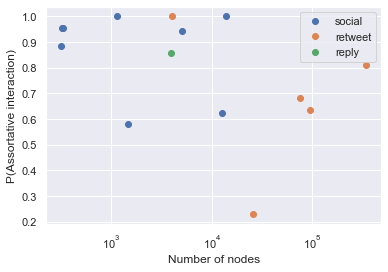

In [96]:
#social network
plt.plot([320,324,329,1133,1463,5042,12645,13861],[0.8833,0.9545,0.9545,1,0.5818,0.9422,0.6257,1],"o",label = "social")
#retweet network
plt.plot([4029,25697,74688,94574,340349],[1,0.2295,0.8461,0.6371,0.8122],"o",label = "retweet")
#reply network
plt.plot([3954],[0.8571],"o",label = "reply")
plt.xscale('log')
plt.xlabel("Number of nodes")
plt.ylabel("P(Assortative interaction)")
plt.gca().legend(("social","retweet","reply"))

In [ ]:
#exact interaction(cp and disass) find the patten then pick one 
#store result in a table
#other networks?

In [90]:
G_gt = gt.load_graph("../Data/new_zealand_collab.xml.gz")

In [93]:
G_gt.ep

{'_graphml_edge_id': <EdgePropertyMap object with value type 'string', for Graph 0x1788ab220, at 0x17ddf8d90>, 'weight': <EdgePropertyMap object with value type 'int16_t', for Graph 0x1788ab220, at 0x17ddf87f0>}